<h1>AI in Fact and Fiction - Summer 2021</h1>
<h2>Introduction to Computer Vision</h2>

<p>

<p>In this lab, you will learn the basics of Computer Vision, how to apply Convolutional Neural Networks, and how to tweak them.</p>

* Use [Google Colab](https://colab.research.google.com/github/AIFictionFact/Summer2021/blob/master/lab2.ipynb) to run the python code, and to complete any missing lines of code.
* You might find it helpful to save this notebook on your Google Drive.
* Please make sure to fill the required information in the **Declaration** cell.
* Once you complete the lab, please download the .ipynb file (File --> Download .ipynb).
* Then, please use the following file naming convention to rename the downloaded python file lab2_YourRCS.ipynb (make sure to replace 'YourRCS' with your RCS ID, for example 'lab2_senevo.ipynb').
* Submit the .ipynb file in LMS.

<p>Due Date/Time: <b>Friday, Jul 2 1.00 PM ET</b></p>

<p>Estimated Time Needed: <b>4 hours</b></p>

<p>Total Tasks: <b>8</b></p>
<p>Total Points: <b>50</b></p>

<hr>


**Declaration**

*Your Name* :

*Collaborators (if any)* :

*Online Resources consulted (if any):*

## Part 1 - Recognizing Handwritten Digits

In this section, you will use a single layer neural network to classify handwritten digits from the MNIST database, that contains handwritten digit images. For more information about MNIST please see http://yann.lecun.com/exdb/mnist.

We'll need the following libraries. 

In [1]:
# Use the following line to install the torchvision library, if it is not already installed
# !conda install -y torchvision

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
from torch.distributions import normal
import time



Use the following function to plot the parameters of the neural network:

In [2]:
  def plot_parameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

Use the following function to visualize the data: 

In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

<h3 id="Makeup_Data">Make Some Data</h3> 

Load the training dataset by setting the parameters <code>train</code> to <code>True</code> and convert it to a tensor by placing a transform object in the argument <code>transform</code> (Do you remember <a href="https://pytorch.org/docs/stable/torchvision/transforms.html">transforms</a> from Lab 1? ;)).

In [4]:
# Create and print the training dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Load the testing dataset by setting the parameters <code>train</code> to <code>False</code> and convert it to a tensor by placing a transform object in the argument <code>transform</code>.

In [5]:
# Create and print the validating dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


You can see that the data type is an integer:

In [6]:
# Print the type of the element
print("Type of data element: ", type(train_dataset[0][1]))

Type of data element:  <class 'int'>


Each element in the rectangular tensor corresponds to a number that represents a pixel intensity as demonstrated by the following image:

<img src="https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/MNIST_1_image_values.png" width="550" alt="MNIST elements" />

In this image, the values are inverted, i.e., black represents white.

Print out the label of the fourth sample:

In [7]:
# Print the label
print("The label: ", train_dataset[3][1])

The label:  1


The result shows the number in the image is 1.

Plot the fourth sample:

The image:  None


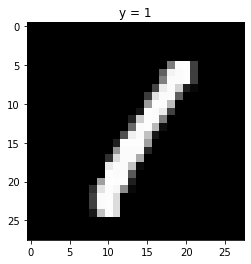

In [8]:
# Plot the image
print("The image: ", show_data(train_dataset[3]))

You see that it is a 1. 

<h3 id="#Classifier">Build a Softmax Classifer</h3>

In [9]:
class SoftMax(nn.Module):
    
    def __init__(self, input_size, output_size):
        """Constructor"""
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        """Prediction"""
        z = self.linear(x)
        return z

The Softmax function requires vector inputs. Note that the vector shape is 28x28.

In [10]:
# Print the shape of train dataset
train_dataset[0][0].shape

torch.Size([1, 28, 28])

Flatten the tensor as shown in this image: 

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/Imagetovector2.png" width="550" alt="Flattern Image" />

The size of the input tensor is 784, and the output tensor is 10 (because it is recognizing the digits from 0-9.)

Set the input size and output size: 

In [11]:
# Set input size and output size
input_dim = 28 * 28
output_dim = 10

Define the Softmax Classifier.

In [12]:
# Create the model
model = SoftMax(input_dim, output_dim)
print("Print the model:\n ", model)

Print the model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


View the size of the model parameters: 

In [13]:
# Print the parameters
print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


You can convert the model parameters for each class (0-9) to a rectangular grid: 

<a><img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/paramaters_to_image.gif" width = 550, align = "center"></a> 

Plot the model parameters for each class as a square image: 

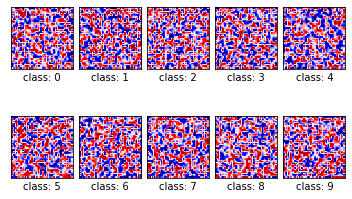

In [14]:
# Plot the model parameters for each class
plot_parameters(model)

Define the learning rate, optimizer, criterion (i.e., the loss funtion), and the data loader:

In [15]:
# Define the learning rate, optimizer, criterion and data loader
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy **(should take a few minutes)**: 

In [16]:
# Train the model
n_epochs = 10
loss_list = []
accuracy_list = []
n_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(n_epochs)

<h3 id="Result">Analyze Results</h3> 
Plot the loss and accuracy on the validation data:

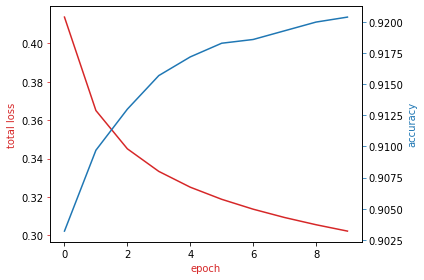

In [17]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for each class after the training. You can see that they look like the corresponding numbers. 

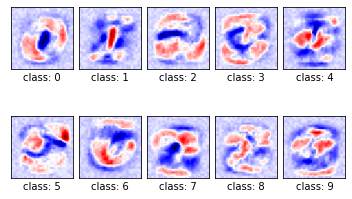

In [18]:
# Plot the parameters
plot_parameters(model)

Let's plot the first five misclassified  samples and the probability of that class.

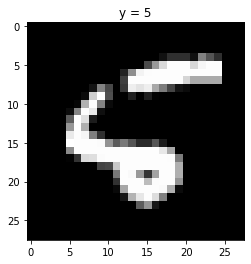

yhat: tensor([6])
probability of class  0.9907020330429077


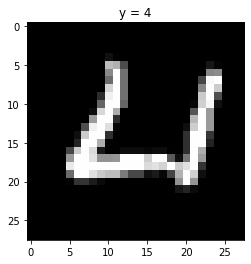

yhat: tensor([6])
probability of class  0.45972275733947754


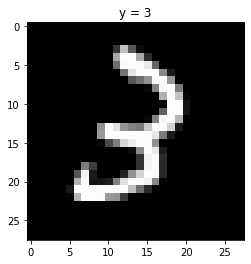

yhat: tensor([2])
probability of class  0.6805424690246582


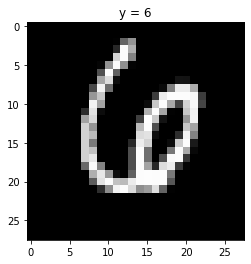

yhat: tensor([7])
probability of class  0.32898083329200745


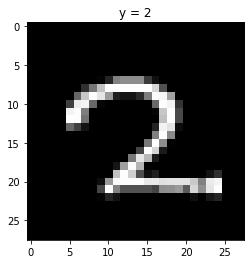

yhat: tensor([7])
probability of class  0.5639716386795044


In [19]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break       

Let's plot the first five correctly classified samples and the probability of that class.

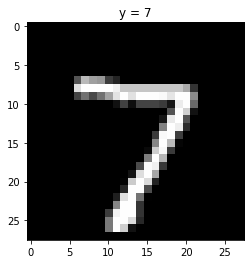

yhat: tensor([7])
probability of class  0.9966784715652466


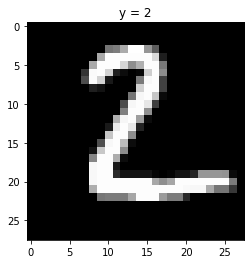

yhat: tensor([2])
probability of class  0.9446921944618225


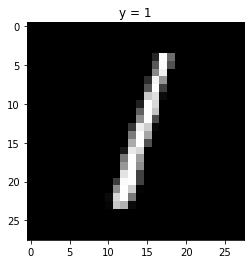

yhat: tensor([1])
probability of class  0.9750949144363403


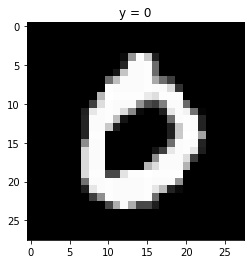

yhat: tensor([0])
probability of class  0.9995846152305603


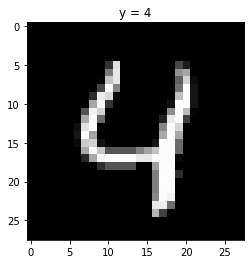

yhat: tensor([4])
probability of class  0.9469379782676697


In [20]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break  

<h3 id="task-01">Task 01 (5 points)</h3>

__(This is a written question)__

What is your observation on the misclassified and correctly classified digits from the MNIST dataset? You may want to check the misclassified and correctly classified samples and their classification probabilities beyond the first five used in the lab. (max 100 words)




_Please type your answer to Task 01 here._

<font color='red'>When the algorithm correctly classified a number, it would usually have a very high probability of being correct. When it misclassified a number, it usually gave itself a lower probability of being correct, but would sometimes give itself a relatively high chance of being correct despite it being incorrect. The majority of the misclassified digits are recognizable to the human eye, so it was likely that the person labeling the digits mistyped when entering the label.</font>

## Part 2 - Convolutional Neural Networks

In this part of the lab, you will study convolution and review how the different operations change the relationship between input and output.

### What is Convolution?

Convolution is a linear operation similar to a linear equation, dot product, or matrix multiplication. Convolution has several advantages for analyzing images as it preserves the relationship between elements, and it requires fewer parameters than other methods. 

You can see the relationship between the different methods that you learned:

$$linear \ equation :y=wx+b$$
$$linear\ equation\ with\ multiple \ variables \ where \ \mathbf{x} \ is \ a \ vector : \mathbf{y}=\mathbf{wx}+b$$
$$ \ matrix\ multiplication \ where \ \mathbf{X} \ is \ a \ matrix : \mathbf{y}=\mathbf{wX}+\mathbf{b} $$
$$\ convolution \ where \ \mathbf{X} \ and \ \mathbf{Y} \ are \ tensors :  \mathbf{Y}=\mathbf{w}*\mathbf{X}+\mathbf{b}$$

Create a two-dimensional convolution object by using the constructor <code>nn.Conv2d</code>, with the parameters <code>in_channels</code>, <code>out_channels</code>, and the parameter <code>kernel_size</code> (which will be set to 3).

In [21]:
conv = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3)
conv

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

Because the weight and bias parameters in <code>nn.Conv2d</code> are randomly initialized and learned through training, give them some initial values.

In [22]:
conv.state_dict()['weight'][0][0]=torch.tensor([[1.0,0,-1.0],[2.0,0,-2.0],[1.0,0.0,-1.0]])
conv.state_dict()['bias'][0]=0.0
conv.state_dict()

OrderedDict([('weight', tensor([[[[ 1.,  0., -1.],
                        [ 2.,  0., -2.],
                        [ 1.,  0., -1.]]]])), ('bias', tensor([0.]))])

Create a dummy tensor to represent an image. The parameters of this dummy tensor correspond to the following:

(number of inputs, number of channels, number of rows, number of columns) 

Then, set the third column to 1:

In [23]:
image=torch.zeros(1,1,5,5)
image[0,0,:,2]=1
image

tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]]]])

Call the object <code>conv</code> on the tensor <code>image</code> as an input to perform the convolution and assign the result to the tensor <code>z</code>. 

In [24]:
z=conv(image)
z

tensor([[[[-4.,  0.,  4.],
          [-4.,  0.,  4.],
          [-4.,  0.,  4.]]]], grad_fn=<ThnnConv2DBackward>)

The following animation illustrates the process. The kernel performs at the element-level multiplication on every element in the image in the corresponding region. The values are then added together. The kernel is then shifted and the process is repeated. 

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/convolution.gif" width = 500, align = "center">

<h3>Determining  the Size of the Output</h3>

The size of the output is an important parameter. In this lab, you will assume square images. For rectangular images, the same formula can be used for each dimension independently.  

Let M be the size of the input and K be the size of the kernel. The size of the output is given by the following formula:
$$M_{new}=M-K+1$$

Let's create a kernel of size 2:

In [25]:
K=2
conv_k2 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=K)
conv_k2.state_dict()['weight'][0][0]=torch.tensor([[1.0,1.0],[1.0,1.0]])
conv_k2.state_dict()['bias'][0]=0.0
conv_k2.state_dict()
conv_k2

Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))

Create an image of size 4:

In [26]:
M = 4
image1=torch.ones(1,1,M,M)

The image and the kernel are as follows:

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/kernal2.png" width = 500, align = "center">

The following equation provides the output:

$$M_{out}=M-K+1$$
$$M_{out}=4-2+1$$
$$M_{out}=3$$

The following animation illustrates the process: The first iteration of the kernel overlay of the images produces one output. As the kernel is of size K, there are M-K  elements for the kernel to move in the horizontal direction. The same logic applies to the vertical direction.

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/outsize.gif" width = 500, align = "center">

Perform the convolution and verify the size is correct:

In [27]:
z_k2=conv_k2(image1)
print("z_k2:",z_k2)
print("shape:",z_k2.shape[2:4])

z_k2: tensor([[[[4., 4., 4.],
          [4., 4., 4.],
          [4., 4., 4.]]]], grad_fn=<ThnnConv2DBackward>)
shape: torch.Size([3, 3])


<h3>Stride parameter</h3>

The parameter stride changes the number of shifts the kernel moves per iteration. As a result, the output size also changes and is given by the following formula:

$$M_{out}=\dfrac{M-K}{stride}+1$$

Create a convolution object with a stride of 2:

In [28]:
conv_s2 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=2,stride=2)

conv_s2.state_dict()['weight'][0][0]=torch.tensor([[1.0,1.0],[1.0,1.0]])
conv_s2.state_dict()['bias'][0]=0.0
conv_s2.state_dict()

OrderedDict([('weight', tensor([[[[1., 1.],
                        [1., 1.]]]])), ('bias', tensor([0.]))])

For an image with a size of 4, here is how we calculate the output size:

$$M_{out}=\dfrac{M-K}{stride}+1$$
$$M_{out}=\dfrac{4-2}{2}+1$$
$$M_{out}=2$$

The following animation illustrates the process: The first iteration of the kernel overlay of the images produces one output. Because the kernel is of size K, there are M-K=2 elements. The stride is 2 because it will move 2 elements at a time. As a result, you divide M-K by the stride value 2:

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/stride2.gif" width = 500, align = "center">

Perform the convolution and verify the size is correct: 

In [29]:
z_s2=conv_s2(image1)

print("z_s2:",z_s2)
print("shape:",z_s2.shape[2:4])

z_s2: tensor([[[[4., 4.],
          [4., 4.]]]], grad_fn=<ThnnConv2DBackward>)
shape: torch.Size([2, 2])


<h3>Zero Padding </h3>
As you apply successive convolutions, the image will shrink. You can apply zero padding to keep the image at a reasonable size, which also holds information at the borders.
In addition, you might not get integer values for the size of the kernel. Consider the following image:

In [30]:
image1

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

Try performing convolutions with the <code>kernel_size=2</code> and a <code>stride=3</code>.

$$M_{out}=\dfrac{M-K}{stride}+1$$
$$M_{out}=\dfrac{4-2}{3}+1$$
$$M_{out}=1.666$$

In [31]:
conv_k2_s3 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=2,stride=3)
conv_k2_s3.state_dict()['weight'][0][0]=torch.tensor([[1.0,1.0],[1.0,1.0]])
conv_k2_s3.state_dict()['bias'][0]=0.0
conv_k2_s3.state_dict()
z_k2_s3=conv_k2_s3(image1)
print("z_k2_s3:",z_k2_s3)
print("z_k2_s3:",z_k2_s3.shape[2:4])

z_k2_s3: tensor([[[[4.]]]], grad_fn=<ThnnConv2DBackward>)
z_k2_s3: torch.Size([1, 1])


You can add rows and columns of zeros around the image. This is called padding. In the constructor <code>Conv2d</code>, you specify the number of rows or columns of zeros that you want to add with the parameter padding. 

For a square image, you merely pad an extra column of zeros to the first column and the last column. Repeat the process for the rows. As a result, for a square image, the width and height is the original size plus 2 x the number of padding elements specified. You can then determine the size of the output after subsequent operations accordingly as shown in the following equation where you determine the size of an image after padding and then applying a convolutions kernel of size K.

$$M'=M+2 \times padding$$
$$M_{out}=M'-K+1$$

Consider the following example:

In [32]:
conv_k2_s3_p1 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=2,stride=3,padding=1)

conv_k2_s3_p1.state_dict()['weight'][0][0]=torch.tensor([[1.0,1.0],[1.0,1.0]])
conv_k2_s3_p1.state_dict()['bias'][0]=0.0
conv_k2_s3_p1.state_dict()
z_k2_s3_p1=conv_k2_s3_p1(image1)
print("z with k=2 s=3 p=1:",z_k2_s3_p1)
print("z with k=2 s=3 p=1:",z_k2_s3_p1.shape[2:4])

z with k=2 s=3 p=1: tensor([[[[1., 2.],
          [2., 4.]]]], grad_fn=<ThnnConv2DBackward>)
z with k=2 s=3 p=1: torch.Size([2, 2])


The process is summarized in the following  animation: 

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/zeropad.gif" width = 500, align = "center">

## Task 02 - Apply convolution (4 points)

Create a random image of size 4 using <code>torch.randn</code>. Define kernel of zeros with a kernel size=3 (please initialize the weight and bias of the kernel convolution object to all zeros). Apply the kernel you defined to the random image you created. 

In [33]:
# Type your code here to define a random image of size 4 (1 point)
image=torch.randn((1,1,4,4))
image

# Type your code here to define a kernel of zeros with a kernel size=3 (2 points)
conv = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3)
conv.state_dict()['weight'][0][0]=torch.tensor([[0,0,0],[0,0,0],[0,0.0,0]])
conv.state_dict()['bias'][0]=0.0

# Type your code here to perform the convolution (1 point)
conv(image)

tensor([[[[0., 0.],
          [0., 0.]]]], grad_fn=<ThnnConv2DBackward>)

### Activation Functions

Just like a neural network, you apply an activation function to the "activation map" obtain through the convolution explained above as shown in the following image:

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/block_digram.png" width = 1000, align = "center">

Create a kernel. Set the weight of the convolution object to the kernal and bias to zero: 

In [34]:
conv = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3)
kernal=torch.tensor([[1.0,0,-1.0],[2.0,0,-2.0],[1.0,0,-1.0]])
conv.state_dict()['weight'][0][0]=kernal
conv.state_dict()['bias'][0]=0.0
conv.state_dict()

OrderedDict([('weight', tensor([[[[ 1.,  0., -1.],
                        [ 2.,  0., -2.],
                        [ 1.,  0., -1.]]]])), ('bias', tensor([0.]))])

Create an image.

In [35]:
image=torch.zeros(1,1,5,5)
image[0,0,:,2]=1
image

tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]]]])

The following depicts the image and kernel we just created: 

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/kernal_out.png" width = 500, align = "center">

Apply convolution to the image: 

In [36]:
z = conv(image)
z

tensor([[[[-4.,  0.,  4.],
          [-4.,  0.,  4.],
          [-4.,  0.,  4.]]]], grad_fn=<ThnnConv2DBackward>)

Apply the activation function to the activation map. This will apply the activation function to each element in the activation map.

In [37]:
relu = nn.ReLU()
a = relu(z)

The process is summarized in the the following figure. The Relu function is applied to each element. All the elements less than zero are mapped to zero. The remaining components do not change.

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/block_example.gif" width = 1000, align = "center">

### Max pooling

Max pooling reduces the number of parameters and makes the network less susceptible to changes in the image. 
Consider the following image: 

In [38]:
image1=torch.zeros(1,1,4,4)
image1[0,0,0,:]=torch.tensor([1.0,2.0,3.0,-4.0])
image1[0,0,1,:]=torch.tensor([0.0,2.0,-3.0,0.0])
image1[0,0,2,:]=torch.tensor([0.0,2.0,3.0,1.0])

image1

tensor([[[[ 1.,  2.,  3., -4.],
          [ 0.,  2., -3.,  0.],
          [ 0.,  2.,  3.,  1.],
          [ 0.,  0.,  0.,  0.]]]])

Max pooling simply takes the maximum value in each region. Consider the following image. For the first region, max pooling simply takes the largest element in a yellow region.   

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/maxpool_1.png" width = 500, align = "center">

If the stride is set to None (its defaults setting), the process will simply take the maximum in a prescribed area and shift over accordingly as shown in the following figure:

<img src = "https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/max_pool_animation_2.gif" width = 500, align = "center">

Here's the code in Pytorch:  

In [39]:
max_pool=torch.nn.MaxPool2d(2) # kernel size = 2
max_pool(image1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[[[2., 3.],
          [2., 3.]]]])

## Task 03 - Apply maxpooling (3 points)

Task 03-1: Create a maxpooling object in 2d to perform max pooling with stride = 1 on <code>image1</code>. (1 point)

Task 03-2: Provide a written answer to the following question (max 200 words).
How does output size change when the stride = 1 compared to the default stride value? What is the reason for the change in the output size (you may explain your answer with the equations introduced earlier)?(2 points)


In [40]:
# Type your code here to apply maxpooling with stride = 1 (1 point)
max_pool=torch.nn.MaxPool2d(2, stride=1)
max_pool(image1)


tensor([[[[2., 3., 3.],
          [2., 3., 3.],
          [2., 3., 3.]]]])

_Please type your answer to Task 03-2 here._

<font color='red'>When you change the stride to one, the output size increases as compared to the default value. This is because of this equation: 

$$M_{out}=\dfrac{M-K}{stride}+1$$

Keeping the same kernel size of 2 and starting an image size of 4, when the stride changes from 2 to 1, the size of the output changes from 2 to 3. 
</font>


<h2>Convolutional Neural Network with Small Images</h2> 

In this part of the lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images with convolution to make them faster to process.

Let's define the function <code>plot_channels</code> to plot out the kernel parameters of each channel. 

In [41]:
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs. 

In [42]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function <code>plot_activation</code> to plot out the activations of the Convolutional layers  

In [43]:
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.

In [44]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<h3 id="Makeup_Data">Get the Data</h3> 

Let's create a transform to resize the image and convert it to a tensor.

In [45]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.

In [46]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Load the testing dataset by setting the parameters train  <code>False</code>.

In [47]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image that you have seen in Lab 02.

<img src="https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/imagenet.png" width="550" alt="MNIST data image">

Print out the fourth label. You will see y=1.

In [49]:
# The label for the fourth data element
train_dataset[3][1]

1

Plot the fourth sample using <code>show_data</code>.

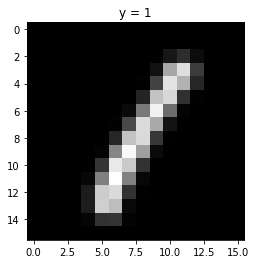

In [50]:
show_data(train_dataset[3])

<h3 id="CNN">Build a Convolutional Neural Network Class</h3>

Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [51]:
class CNN(nn.Module):
    
    def __init__(self, out_1=16, out_2=32):
        """Contructor"""
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    def forward(self, x):
        """Prediction"""
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    def activations(self, x):
        """outputs activation"""
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

<h3 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h3> 
There are 16 output channels for the first layer, and 32 output channels for the second layer 

In [52]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.

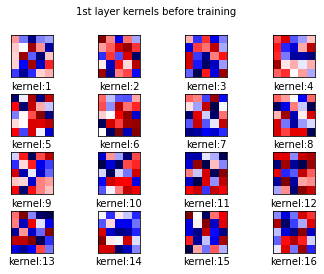

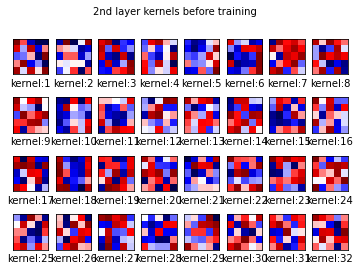

In [53]:
# Plot the parameters
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer and the dataset loader.

In [54]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation/test accuracy. **(This may take a long time)**

In [55]:
# Train the model
n_epochs=3
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    start = time.time()
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
    print('%.2f sec to train the basic CNN' % (time.time() - start))
     
train_model(n_epochs)

64.11 sec to train the basic CNN


<h3 id="Result">Analyze Results</h3> 
Plot the loss and accuracy on the validation data:

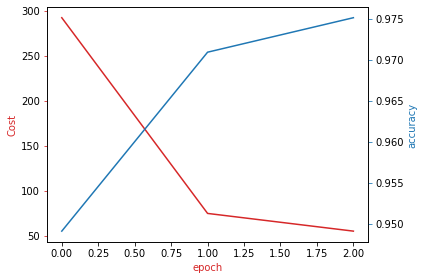

In [56]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 

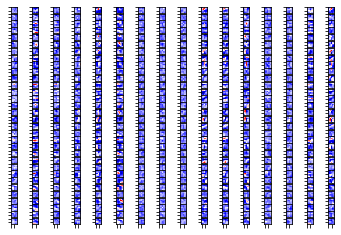

In [57]:
# Plot the channels
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample.

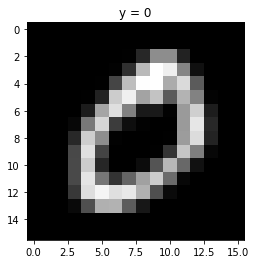

In [58]:
# Show the second image
show_data(train_dataset[1])

Determine the activations.

In [59]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activation.

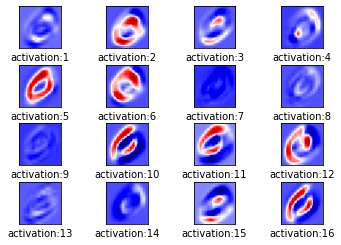

In [60]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 

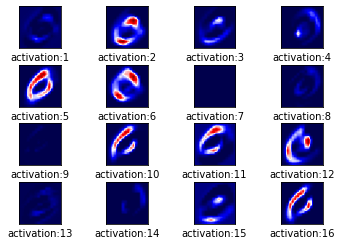

In [61]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.

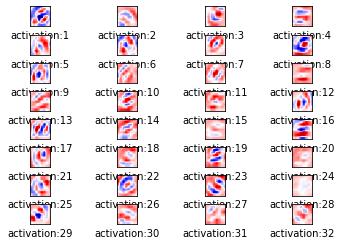

In [62]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu.  

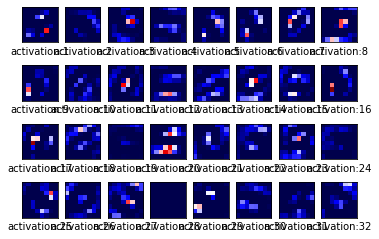

In [63]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

## Task 04 - Analyze the result for the third training sample (10 points)

Similar to the process outlined above, please write code to complete the following. 
* Display the third sample using <code>show_data</code>. (2 points)
* Use the CNN activations class to see the steps in training for this sample. (4 points)
* Plot the outputs after the first convolution. (1 point)
* Plot the outputs after the first relu. (1 point)
* Plot the outputs after the second convolution.(1 point)
* Plot the outputs after the second relu. (1 point)

Please type your code in the corresponding cells below. 

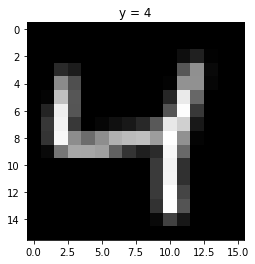

In [64]:
# Type your code here to display the third sample using show_data. (2 points)
show_data(train_dataset[2])

In [65]:
# Type your code here to use the CNN activations class to see the steps in training for this sample. (4 points)
out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

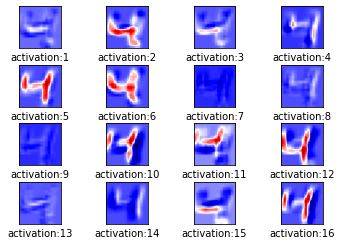

In [66]:
# Type your code here to plot the outputs after the first convolution. (1 point)
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

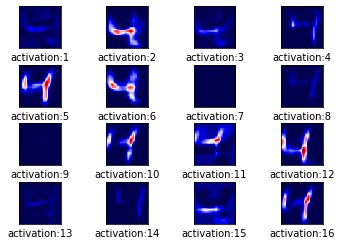

In [67]:
# Type your code here to plot the outputs after the first relu. (1 point)
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

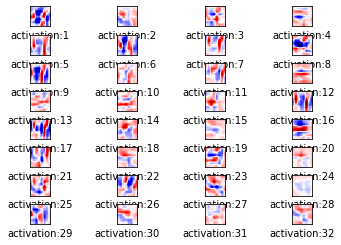

In [68]:
# Type your code here to plot the outputs after the second convolution.(1 point)
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

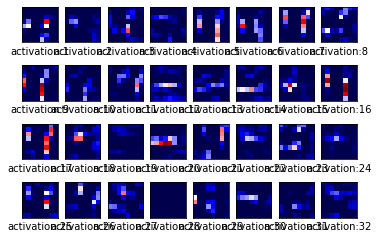

In [69]:
# Type your code here to plot the outputs after the second relu. (1 point)
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

## Task 05 - Analyze misclassified images in the MNIST validation dataset (10 points)

Task 05-1: Earlier in the lab you saw how to plot the correctly classified and misclassified images. Complete the function <code>lab2_task5_1</code> that will print 5 misclassified digit images. (3 points)

Task 05-2: __(This is a written answer question.)__ Please compare the level of misclassification of digits you saw earlier in this lab for Task 01 vs. the ones you see for this task. (2 points)

Task 05-3: __(This is a written answer question.)__ What are your thoughts on the test accuracy of CNNs? (2 points)

Task 05-4: __(This is a written answer question.)__ What are some strategies for increasing the accuracy? (3 points)


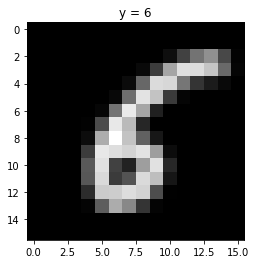

yhat: tensor([5])
probability of class  0.8502917885780334


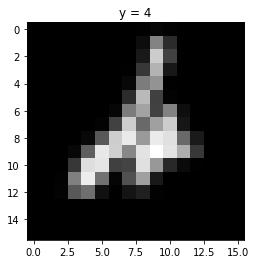

yhat: tensor([2])
probability of class  0.6049619913101196


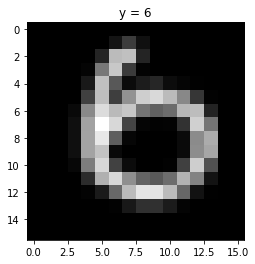

yhat: tensor([0])
probability of class  0.9432532787322998


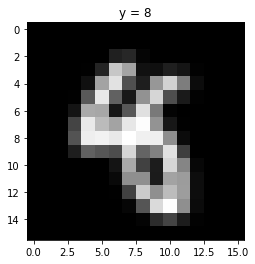

yhat: tensor([5])
probability of class  0.662540853023529


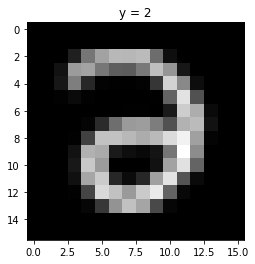

yhat: tensor([3])
probability of class  0.507946252822876


In [70]:
# Type your code here to complete this function that will print 5 misclassified digit images
def lab2_task5_1():
  Softmax_fn=nn.Softmax(dim=-1)
  count = 0
  for x, y in validation_dataset:
    z = model(x.unsqueeze(0))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break

lab2_task5_1()


_(Please type your answer to Task 05-2 here.)_

<font color='red'>
Full points are only awarded for picking several (or at least one) misclassified image(s) this task and comparing the results for the same image in task 1. It is not sufficient to provide a blanket statement about the misclassified images you would have seen in the previous question. That would not be a proper comparison for the two AI models.
</font>

_(Please type your answer to Task 05-4 here.)_

<font color='red'>
The level of misclassification is lower in this task. The number of misclassified digits was only a few hundred for the CNN, but for the model in question for task 1, the number of wrong guesses was in the thousands.
</font>




_(Please type your answer to Task 05-3 here.)_

<font color='red'>

* Having a larger dataset for training
*	Improving the labels of the training data, especially for very badly handwritten digits (as some of the labels in the dataset seem to be erroneous that could throw off the accuracy of the model)
*	Using more hidden layers
*	Changing activation functions
*	Make sure the stride size is at an optimal value
*	Finding optimal number for training epochs
*	Better convolution models that look at different orientations, lengths, etc.
*	Having fully-connected 'Dense' layers instead of linear layers
</font>


## Part 3 - Applying CNN to Fashion-MNIST

You may have noticed that even simple models achieve classification accuracy over 95% on MNIST, so it is hard to spot the differences between better models and weaker ones. In order to get a better intuition, we will use the qualitatively similar, but comparatively complex [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

Download the FashioMNIST data. Recall that the <code>ToTensor</code> Transform also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations introduced later.

In [71]:
trans = transforms.ToTensor()
fashion_mnist_train = dsets.FashionMNIST(root="./data", train=True, transform=trans, target_transform=None, download=True)
fashion_mnist_test = dsets.FashionMNIST(root="./data", train=False, transform=trans, target_transform=None, download=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



The number of images for each category in the training set and the testing set is 6,000 and 1,000, respectively. Since there are 10 categories, the numbers of examples in the training set and the test set are 60,000 and 10,000, respectively.

In [72]:
len(fashion_mnist_train), len(fashion_mnist_test)

(60000, 10000)

We can access any example by indexing into the dataset using square brackets []. In the following code, we access the image and label corresponding to the first example.

In [73]:
feature, label = fashion_mnist_train[0]

Our example, stored here in the variable feature corresponds to an image with a height and width of 28 pixels. PyTorch automatically scales it into a tensor with each pixel value between 0 and 1. It is stored in a 3D Tensor. Its first dimension is the number of channels. Since the data set is a grayscale image, the number of channels is 1. When we encounter color images, we'll have 3 channels for red, green, and blue. To keep things simple, we will record the shape of the image with the height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or (h, w).

In [74]:
feature.shape, feature.dtype

(torch.Size([1, 28, 28]), torch.float32)

The label of each image is represented as a scalar in PyTorch. Its type is a 64-bit integer.

In [75]:
label, type(label)

(9, int)

There are 10 categories in Fashion-MNIST: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. The following function can convert a numeric label into a corresponding text label.



In [76]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

The following defines a function that can draw multiple images and corresponding labels in a single line.

In [77]:
def show_fashion_mnist(images, labels):
    # Here _ means that we ignore (not use) variables
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

Next, let's take a look at the image contents and text labels for the first nine examples in the training data set.

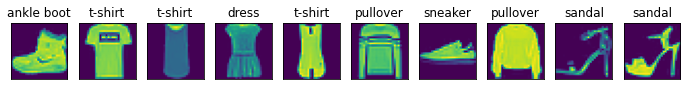

In [78]:
X=[]
y=[]
for idx, data in enumerate(fashion_mnist_train):
    if(idx>=0 and idx<10):
        X.append(data[0])
        y.append(data[1])
    if (idx>=10):
        break
# X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

To make our life easier when reading from the training and test sets we use a <code>DataLoader</code>. Recall that a <code>DataLoader</code> object reads a mini-batch of data with an example number of <code>batch_size</code> each time.

In practice, reading data can often be a significant performance bottleneck for training, especially when the model is simple or when the computer is fast. A handy feature of PyTorch's <code>DataLoader</code> is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via <code>num_workers</code>).

In [79]:
batch_size = 256
num_workers = 4

fashion_train_loader = DataLoader(fashion_mnist_train, batch_size, shuffle=True, num_workers=num_workers)
fashion_test_loader = DataLoader(fashion_mnist_test, batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's apply a simple softmax regression to the fashionMNIST dataset (very similar to how we applied regression with mini-batch gradient descent to the MNIST digit dataset in lab 02). In softmax regression, we have as many outputs as there are categories. Because our dataset has $10$ categories, our network will have an output dimension of $10$. Consequently, our weights will constitute a $784 \times 10$ matrix and the biases will constitute a $1 \times 10$ vector. 

In [80]:
num_inputs = 784
num_outputs = 10

W = normal.Normal(loc = 0, scale = 0.01).sample((num_inputs, num_outputs))
b = torch.zeros(num_outputs)

Recall that we need to attach gradients to the model parameters. Here we are allocating memory for future gradients to be stored and notifiying PyTorch that we want gradients to be calculated with respect to these parameters in the first place.

In [81]:
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

The softmax function is defined as follows.

In [82]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition

Now that we have defined the softmax operation, we can implement the softmax regression model. The below code defines the forward pass through the network. Note that we flatten each original image in the batch into a vector with length num_inputs with the view function before passing the data through our model.

In [83]:
def basic_net(X):
    return softmax(torch.matmul(X.reshape((-1, num_inputs)), W) + b)

Loss function is defined as follows:

In [84]:
cross_entropy = nn.CrossEntropyLoss()

Given the predicted probability distribution <code>y_hat</code>, we typically choose the class with highest predicted probability whenever we must output a hard prediction. 

To compute accuracy we do the following: First, we execute <code>y_hat.argmax(dim=1)</code> to gather the predicted classes (given by the indices for the largest entries in each row). The result has the same shape as the variable y. Now we just need to check how frequently the two match. The result is PyTorch tensor containing entries of 0 (false) and 1 (true). Since the attribute mean can only calculate the mean of floating types, we also need to convert the result to float. Taking the mean yields the desired result.

In [85]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

Similarly, we can evaluate the accuracy for model net on the data set (accessed via <code>data_iter</code>).

In [86]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.size()[0]  # y.size()[0] = batch_size
    return acc_sum / n

Train the model. **This may take some time**.

In [87]:
num_epochs, lr = 5, 0.1

def train_model_basic(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                # Use mini-batch gradient descent
                for param in params:
                    param.data.sub_(lr*param.grad/batch_size)
                    param.grad.data.zero_()
            else:
                # This will be illustrated in the next section
                trainer.step(batch_size)
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.size()[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_model_basic(basic_net, fashion_train_loader, fashion_test_loader, cross_entropy, num_epochs, batch_size, [W, b], lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.0090, train acc 0.173, test acc 0.196
epoch 2, loss 0.0090, train acc 0.209, test acc 0.224
epoch 3, loss 0.0090, train acc 0.229, test acc 0.238
epoch 4, loss 0.0090, train acc 0.240, test acc 0.245
epoch 5, loss 0.0090, train acc 0.247, test acc 0.252


Now that training is complete, our model is ready to classify some images. Given a series of images, we will compare their actual labels (first line of text output) and the model predictions (second line of text output).

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


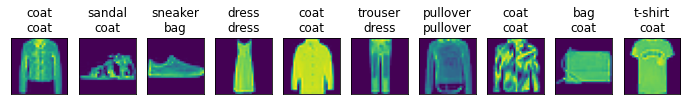

In [88]:
for X, y in fashion_test_loader:
    break

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(basic_net(X).argmax(dim=1).numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

show_fashion_mnist(X[10:20], titles[10:20])

### Applying CNN to Fashion-MNIST

We are now ready to put all of the tools together to deploy your first fully-functional convolutional neural network for the Fashion-MNIST dataset. To make this data amenable to multilayer perceptrons which anticapte receiving inputs as one-dimensional fixed-length vectors, we first flatten each image, yielding vectors of length 784, before processing them with a series of fully-connected layers. The following two classes define the flattening and reshaping process.

In [89]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)

The following neural net, implemented as a simple PyTorch [Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) module container, is one of the first published convolutional neural networks whose benefit was first demonstrated by Yann Lecun for the purpose of recognizing handwritten digits in images—[LeNet5](http://yann.lecun.com/exdb/lenet/). (That is why we have named this network *le_net*)

In [90]:
le_net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

Now that we've implemented the model, let's run some experiments to see what we can accomplish with the LeNet model. 

In [91]:
def evaluate_accuracy_updated(data_iter, net,device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    acc_sum,n = torch.tensor([0],dtype=torch.float32,device=device),0
    for X,y in data_iter:
        # If device is the GPU, copy the data to the GPU.
        X,y = X.to(device),y.to(device)
        net.eval()
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0]
    return acc_sum.item()/n

Here is a simple function that we can use to detect whether we have a GPU. In it, we try to allocate gpu0 if available using torch.cuda.is_available() method. Otherwise, we stick with the CPU. For more information about PyTorch's device API, please see https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device.

In your colab notebook settings, please remember to set the "Runtime" -> "Change Runtime Type" -> and in the "Hardware accelerator" drop-down list, select "GPU."

<img src="https://raw.githubusercontent.com/AIFictionFact/Summer2021/main/images/gpu_settings.png" width="200"/>

In [92]:
def try_gpu():
    """If GPU is available, return torch.device as cuda:0; else return torch.device as cpu."""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()

Here is the training function. Note that we need to move each batch of data to our designated device (hopefully, the GPU) prior to making the forward and backward passes. 


In [93]:
def train_model_lenet(net, train_iter, test_iter,criterion, num_epochs, batch_size, device,lr=None):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_l_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        train_acc_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        n, start = 0, time.time()
        for X, y in train_iter:
            net.train()
            
            optimizer.zero_grad()
            X,y = X.to(device),y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]
        test_acc = evaluate_accuracy_updated(test_iter, net,device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc,
                 time.time() - start))

The loss function and the training algorithm still use the cross-entropy loss function and mini-batch stochastic gradient descent. We did not cover Xavier initializer in class, and if you are interested in learning more please check the PyTorch documentation.

In [94]:
lr, num_epochs = 0.9, 5

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

le_net.apply(init_weights)
le_net = le_net.to(device)

criterion = nn.CrossEntropyLoss()
fashion_train_loader_le_net = DataLoader(fashion_mnist_train, batch_size, shuffle=True, num_workers=num_workers)
fashion_test_loader_le_net = DataLoader(fashion_mnist_test, batch_size, shuffle=False, num_workers=num_workers)

train_model_lenet(le_net, fashion_train_loader_le_net, fashion_test_loader_le_net, criterion,num_epochs, batch_size,device, lr)

training on cpu


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.0091, train acc 0.100, test acc 0.100, time 22.2 sec
epoch 2, loss 0.0074, train acc 0.264, test acc 0.511, time 21.7 sec
epoch 3, loss 0.0038, train acc 0.611, test acc 0.659, time 21.8 sec
epoch 4, loss 0.0031, train acc 0.693, test acc 0.720, time 21.7 sec
epoch 5, loss 0.0027, train acc 0.736, test acc 0.718, time 21.9 sec


## Task 06 - Analyze classification accuracy of images in the Fashion-MNIST validation dataset (5 points)

Write code to analyze the classification accuracy of the FashionMNIST validatiion dataset. You must compare the actual labels of the images against the model predictions. You may find it helpful to print the images as we have already seen for the output from the basic CNN. (5 points)

In [95]:
# Type your code here to analyze the image classification results
labels = []
get_fashion_mnist_labels(labels)

start = time.time()
le_net = le_net.to(device)
num_correct = 0
num_incorrect = 0
total = 0
for x, y in fashion_mnist_test:
    x = torch.tensor(x)
    y = torch.tensor(y)
    x,y = x.to(device),y.to(device)
    y_hat = le_net(x)
    if (torch.sum((torch.argmax(y_hat, dim=1) == y))):
        num_correct += 1
    else:
        num_incorrect += 1
    total += 1
end = time.time() - start
print("{} Images classified correctly: {:.2f}%".format(num_correct, num_correct / total))
print("{} Images classified incorrectly: {:.2f}%".format(num_incorrect, num_incorrect / total))
print("Took {:.3f} seconds:".format(end))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


7183 Images classified correctly: 0.72%
2817 Images classified incorrectly: 0.28%
Took 6.501 seconds:


## Task 07 - Improve LeNet (10 points)

Task 07-1: Construct a more complex network based on LeNet to improve its accuracy. You must demonstrate that your model has a higher accuracy compared to the vanilla <code>le_net</code> given in the lab. Be creative! (5 points)

Here are several things you can try:
* Adjust the convolution window size.
* Adjust the number of output channels.
* Adjust the activation function (e.g., try ReLU and/or Tanh).
* Adjust the number of convolution layers.
* Adjust the number of fully connected layers.
* Adjust the learning rates and other training details (initialization, epochs, etc.)

Task 07-2: Write code to try the new and improved <code>le_net</code> network on the FashionMNIST dataset. (2 points)

Task 07-3: __(This is a written answer question.)__ Summarize the results of your trials in constructing the new and improved <code>le_net</code>. (3 points)


In [96]:
# Task 07-1: Type your code here to improve le_net
le_net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, padding=2),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=2, out_channels=16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)


In [97]:
# Task 07-2: Type your code here to apply the improved le_net on FashionMNIST
train_model_lenet(le_net, fashion_train_loader_le_net, fashion_test_loader_le_net, criterion,num_epochs, batch_size,device, lr=0.5)
train_accuracy = evaluate_accuracy_updated(fashion_train_loader_le_net, le_net)
test_accuracy = evaluate_accuracy_updated(fashion_test_loader_le_net, le_net)
print(train_accuracy)
print(test_accuracy)

training on cpu


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.0029, train acc 0.723, test acc 0.768, time 19.0 sec
epoch 2, loss 0.0018, train acc 0.832, test acc 0.813, time 19.0 sec
epoch 3, loss 0.0016, train acc 0.853, test acc 0.839, time 18.8 sec
epoch 4, loss 0.0014, train acc 0.864, test acc 0.832, time 19.0 sec
epoch 5, loss 0.0013, train acc 0.873, test acc 0.861, time 18.9 sec
0.8796333333333334
0.8614


_(Please type your answer to Task 07-3 here)_
<font color='red'>The best results seem to be with the application of tanh as the activation function instead of sigmoid, changing the learning rate, and finding an optimal balance of the number of epochs used in the training process, which seems to be between 8-10. This yields 87.5% - 89% accuracy. Other slight improvements may include changing kernel size, stride values, and changing input/output ratios and values.</font>

## Task 08 - Other modern CNN Experimentation (3 points)

Experiment with at least one other modern CNNs such as [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) (or some other highly performant model for image data) on the Fashion MNIST dataset. Include your code in the designated cell below. Clearly indicate the model you utilized and the online documentation or the relevant academic paper containing more information about that model.

In [ ]:
# Task 08 - Type your code here 
# As long as you have demonstrated that you experimented with a
# state of the art CNN, we offered full points for this task.
# For example, here is a Google Colab python notebook that details how to run Alexnet:
# https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/single-core-alexnet-fashion-mnist.ipynb
# This takes some time to train (on a Google Colab TPU cloud, it took me 8.61 
# minutes), but the results were pretty good ~ 88.9% accuracy.
